### Library Imports

In [282]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import vaex
import shapefile as sh
from h3 import h3
from shapely.geometry import shape
import json
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, LinearRing
import folium
from folium.plugins import HeatMap
import shapely
import math

Quelle von den Daten hinzufügen

## Testing of general method with simple coordinates

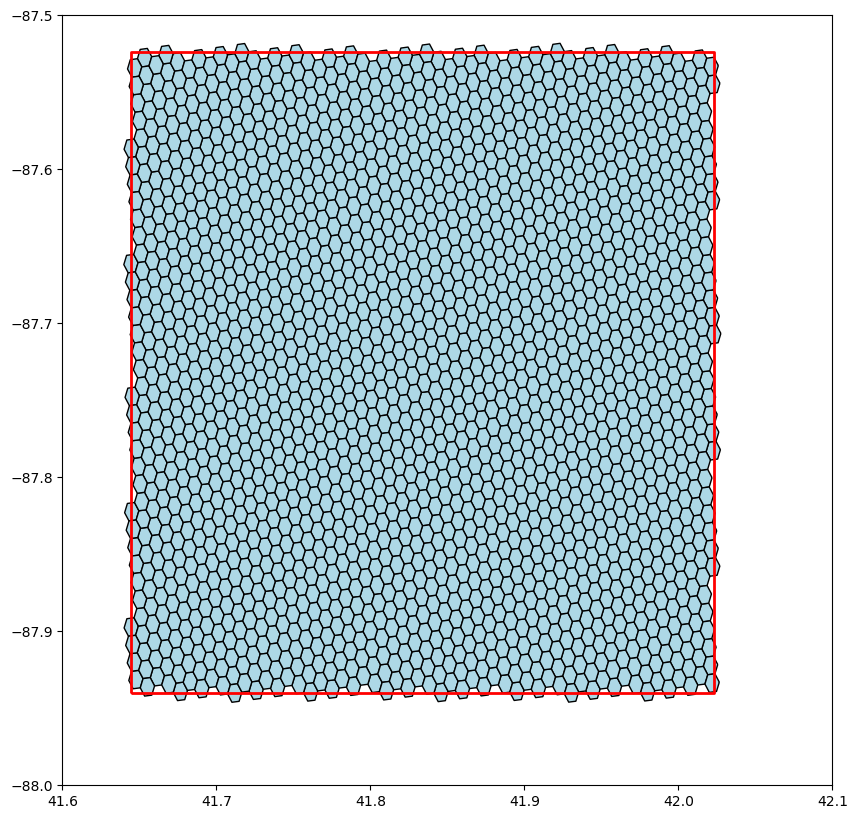

In [230]:
# Step 1: Define the boundary coordinates of Chicago (in this case just the shape of a quadrant)
chicago_boundary = [
    [41.64454, -87.94013],
    [41.64454, -87.52399],
    [42.02303, -87.52399],
    [42.02303, -87.94013]
]

# Step 2: Define resolution level
resolution = 8

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill_polygon(chicago_boundary, resolution)

# Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(chicago_boundary)
hexagons_within_city = [
    hexagon for hexagon in hexagons
    if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))
]


# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [
    Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True))
    for hexagon in hexagons_within_city
]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

#Transform Y to X Coordinates and the other way arround to match structure from the chicago boundary
hexagon_gdf = hexagon_gdf.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the hexagons
hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[chicago_polygon])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_ylim(-88, -87.5)
ax.set_xlim(41.6, 42.1)

# Display the plot
plt.show()

In [218]:
#Possibility to explore the data within an add-on from folium to the geopandas dataframe
#hexagon_gdf.explore()

In [291]:
import json
city_bounding_box = gpd.read_file('data/trips/Boundaries - City.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

<Axes: >

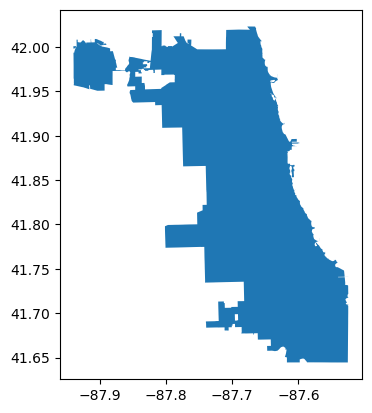

In [299]:
city_bounding_box.plot()

In [293]:
city_bounding_box_poly

{'id': '0',
 'type': 'Feature',
 'properties': {'name': 'CHICAGO',
  'objectid': '1',
  'shape_area': '6450276623.31',
  'shape_len': '845282.931362'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-87.93514385942143, 42.00088911607326],
     [-87.9352110270025, 42.00081664143955],
     [-87.93529133950187, 42.00072700895027],
     [-87.93551196383594, 42.000480781935586],
     [-87.93574247939097, 42.00025812301311],
     [-87.93584505940073, 42.000159039381906],
     [-87.93590356821541, 42.00010497538239],
     [-87.93598608216818, 42.00001374987231],
     [-87.93632784066214, 41.99960326946243],
     [-87.9366154497264, 41.99923337944194],
     [-87.93677128867272, 41.999023248278675],
     [-87.9368759749499, 41.998881847153044],
     [-87.93693408810181, 41.99880335510703],
     [-87.93706164890665, 41.998612362462175],
     [-87.93707950926456, 41.998585741964575],
     [-87.93905445886887, 41.99826104013864],
     [-87.93982896518334, 41.99813745944146],
     [-87.

The loaded geojson file contains MultiPolygon shapes that cannot be used in "certain" functions, which is why we need to convert them to Polygons

In [297]:
len(city_bounding_box_poly['geometry']['coordinates'][0][0])

32

In [222]:
# Read GeoJSON file
with open('data/trips/Boundaries - City.geojson') as f:
    data = json.load(f)

# Iterate over features
for feature in data['features']:
    # Check if geometry is a MultiPolygon
    if feature['geometry']['type'] == 'MultiPolygon':
        multi_polygon = shape(feature['geometry'])

        # Convert MultiPolygon into individual polygons
        polygons = list(multi_polygon.geoms)

        # Update feature geometry with individual polygons
        feature['geometry'] = {
            'type': 'Polygon',
            'coordinates': [poly.exterior.coords[:] for poly in polygons]
        }

# Save modified GeoJSON file
with open('output.geojson', 'w') as f:
    json.dump(data, f)

In [223]:
city_bounding_box = gpd.read_file('./output.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

<Axes: >

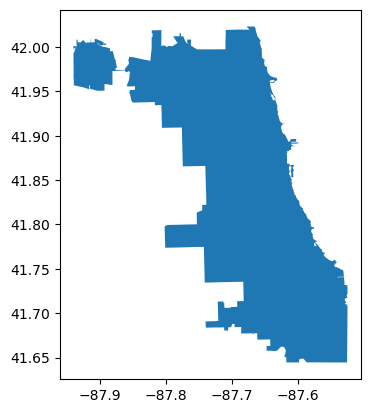

In [224]:
#Validation check if we still have the same datapoints
city_bounding_box.plot()

In [265]:
#Second Validation Check for the data
city_bounding_box_poly

{'id': '0',
 'type': 'Feature',
 'properties': {'name': 'CHICAGO',
  'objectid': '1',
  'shape_area': '6450276623.31',
  'shape_len': '845282.931362'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-87.93514385942143, 42.00088911607326],
    [-87.9352110270025, 42.00081664143955],
    [-87.93529133950187, 42.00072700895027],
    [-87.93551196383594, 42.000480781935586],
    [-87.93574247939097, 42.00025812301311],
    [-87.93584505940073, 42.000159039381906],
    [-87.93590356821541, 42.00010497538239],
    [-87.93598608216818, 42.00001374987231],
    [-87.93632784066214, 41.99960326946243],
    [-87.9366154497264, 41.99923337944194],
    [-87.93677128867272, 41.999023248278675],
    [-87.9368759749499, 41.998881847153044],
    [-87.93693408810181, 41.99880335510703],
    [-87.93706164890665, 41.998612362462175],
    [-87.93707950926456, 41.998585741964575],
    [-87.93905445886887, 41.99826104013864],
    [-87.93982896518334, 41.99813745944146],
    [-87.93989441399762, 41.9981

We can see that the geometry type has changed to Polygon

In [268]:
chicago_boundary = city_bounding_box_poly["geometry"]["coordinates"][0]

In [290]:
len(chicago_boundary)

32

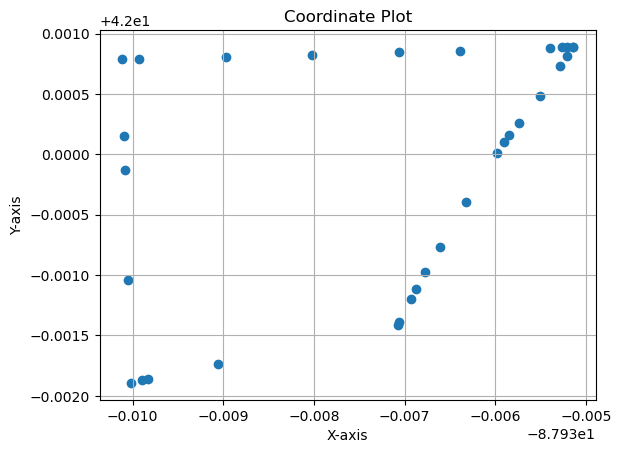

In [287]:
# Extract x and y coordinates from the list
x_coordinates = [coord[0] for coord in chicago_boundary]
y_coordinates = [coord[1] for coord in chicago_boundary]

# Create a scatter plot
plt.scatter(x_coordinates, y_coordinates)

# Customize the plot if needed
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Coordinate Plot')
plt.grid(True)

# Display the plot
plt.show()



In [284]:
chicago_polygon =Polygon(chicago_boundary)

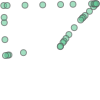

In [283]:
chicago_polygon

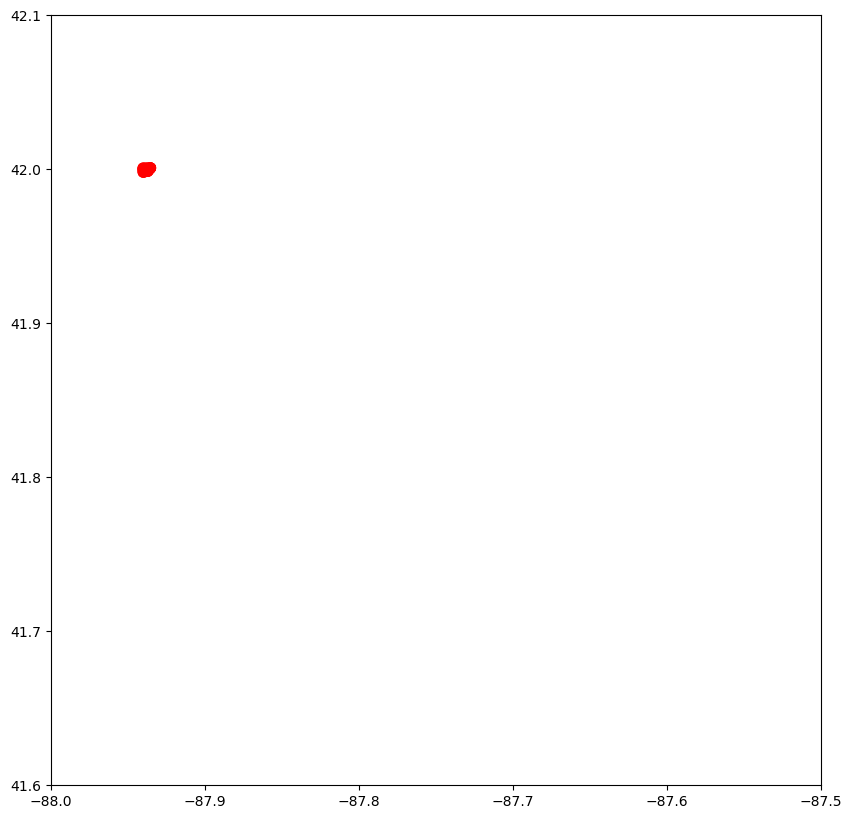

In [280]:
#Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[chicago_polygon])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)

# Display the plot
plt.show()

In [ ]:
gdf = city_bounding_box

In [ ]:
gdf = gpd.GeoSeries.to_crs(gdf, crs =4326)

In [ ]:
city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)


In [ ]:
def create_hexagons(row):
    boundary = row['geometry']
    hex_coords = []
    for coords in boundary.exterior.coords:
        hex_coords.append([coords[1], coords[0]])
    hexagon = folium.vector_layers.Polygon(locations=hex_coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.4)
    hexagon.add_to(city_map)


In [ ]:
gdf.apply(create_hexagons)


In [ ]:
gdf = city_bounding_box


In [ ]:
gdf = gpd.GeoSeries.to_crs(gdf["geometry"], crs =4326)

In [ ]:
city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)

In [ ]:
city_bounding_box.plot()

In [ ]:
city_bounding_box_poly

In [ ]:
hexagons = []

In [ ]:
city_bounding_box_poly['geometry']["coordinates"][0]

In [ ]:
# Step 2: Define the desired resolution level
resolution = 14

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill(city_bounding_box_poly['geometry'], resolution)

# Step 4: Remove hexagons outside the city
# Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(city_bounding_box_poly['geometry']["coordinates"][0])
hexagons_within_city = [hexagon for hexagon in hexagons if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))]


In [ ]:
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
# df = gpd.GeoDataFrame(list(hexagons_within_city), columns=['h3_hex_id'])

df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

In [ ]:
df.plot()

In [ ]:
hexagon = folium.vector_layers.Polygon(locations=city_bounding_box_poly['geometry']["coordinates"][0], color='blue', fill=True, fill_color='blue', fill_opacity=0.4)
hexagon.add_to(city_map)

In [ ]:
gdf.apply(create_hexagons)


In [ ]:
# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the hexagons
# hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[city_bounding_box])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_xlim(-87.98, -87.90)
ax.set_ylim(41.99, 42.01)

# Display the plot
plt.show()

In [ ]:
polygon_h3 = h3.polyfill(city_bounding_box_poly['geometry'], res=13)
hexagons.extend(polygon_h3)

In [ ]:
hexagons

In [ ]:
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

In [ ]:
from shapely.geometry import Polygon

hexagons_vertices = [h3.h3_to_geo_boundary(h) for h in hexagons]
hexagons_flat = [coord for vertices in hexagons_vertices for coord in vertices]
hexagons_gdf = gpd.GeoDataFrame(geometry=[Polygon(hexagons_flat)], crs='EPSG:4326')



In [ ]:
hexagons_gdf.plot()


In [ ]:
# Computing hexagons for a given polygon
H3_HEXAGON_RESOLUTION = 11
polygon_obj = city_bounding_box_poly['geometry'] # your geo json object
hexagons = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION, geo_json_conformant = True)


In [ ]:
# Returns only the index of each hexagon, not the geometries
hexagons

In [ ]:
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

In [ ]:
df.plot()

## Overview over Illinoi as a state (testing of different additional datapoints)

<Axes: >

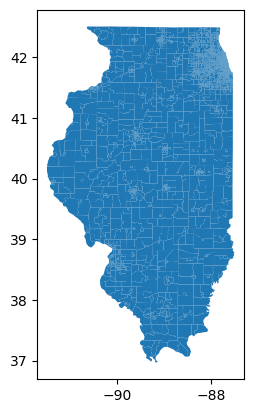

In [226]:
shape = gpd.read_file('data/poi/cb_2022_17_tract_500k.shp')
shape.plot()

In [227]:
# Load the census tract shapefile for Chicago
shapefile_path = 'data/poi/cb_2022_17_tract_500k.shp'
chicago_map = gpd.read_file(shapefile_path)


In [228]:
print(chicago_map.info)

<bound method DataFrame.info of      STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME   
0         17      143  004600  1400000US17143004600  17143004600       46  \
1         17      143  000300  1400000US17143000300  17143000300        3   
2         17      073  030600  1400000US17073030600  17073030600      306   
3         17      073  030900  1400000US17073030900  17073030900      309   
4         17      107  953200  1400000US17107953200  17107953200     9532   
...      ...      ...     ...                   ...          ...      ...   
3258      17      201  003706  1400000US17201003706  17201003706    37.06   
3259      17      089  851301  1400000US17089851301  17089851301  8513.01   
3260      17      019  005402  1400000US17019005402  17019005402    54.02   
3261      17      031  410600  1400000US17031410600  17031410600     4106   
3262      17      043  846603  1400000US17043846603  17043846603  8466.03   

                  NAMELSAD STUSPS        NA